In [12]:
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from keras.layers import Dropout

In [13]:
# load the dataset
df = pd.read_csv('./data/ml-latest-small/ratings.csv')

In [14]:
# preprocessing
# binary implicit feedback
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 3.0 else 0)

# total user and movie count
n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

# train test split
train, validation = train_test_split(df, test_size=0.2, random_state=42)

# user id indexing
unique_user_ids = df['userId'].unique()
userId_dict = {id: i for i, id in enumerate(unique_user_ids)}

# movie id indexing
unique_movie_ids = df['movieId'].unique()
movieId_dict = {id: 1 for i, id in enumerate(unique_movie_ids)}

# id mapping using indexed dictionary
train['userId'] = train['userId'].map(userId_dict)
train['movieId'] = train['movieId'].map(movieId_dict)

validation['userId'] = validation['userId'].map(userId_dict)
validation['movieId'] = validation['movieId'].map(movieId_dict)

# total unique user count
num_unique_users = df['userId'].nunique() + 1
# total unique movie count
num_unique_movies = df['movieId'].nunique() + 1


In [15]:
train.movieId

80568    1
50582    1
8344     1
99603    1
71701    1
        ..
6265     1
54886    1
76820    1
860      1
15795    1
Name: movieId, Length: 80668, dtype: int64

In [16]:
auc = tf.keras.metrics.AUC()

In [17]:
# save losses per each drop rate
loss_df = pd.DataFrame()

# MLP function
def create_mlp(hidden_layers, output, dropout_rate):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
            hidden = Dropout(dropout_rate)(hidden)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
            hidden = Dropout(dropout_rate)(hidden)
    output = Dense(1, activation='sigmoid')(hidden)
    return output

# dropout rates
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

for rate in dropout_rates:
    
    # user/item input layer
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))
    
    # embedding dimension
    n_latent_factors = 20
    
    # embedding layers
    user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
    movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)
    
    # flatten embeddings
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)
    
    # concat embeddings
    concat = Concatenate()([user_embedding, movie_embedding])
    
    output = create_mlp([64, 64], concat, rate)
    
    # model
    model = Model(inputs=[user_input, movie_input], outputs=output)
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])
    
    # fit the model
    history = model.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=2,
                        validation_data=([validation.userId, validation.movieId], validation.rating))
    
    # append loss value to the df
    loss_df[f'dropout_rate_{rate}_train'] = history.history['loss']
    loss_df[f'dropout_rate_{rate}_val'] = history.history['val_loss']
    
    del model

Epoch 1/10


d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_12', 'keras_tensor_13']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 4s - 1ms/step - accuracy: 0.8159 - auc_1: 0.7224 - loss: 0.4336 - val_accuracy: 0.8106 - val_auc_1: 0.7421 - val_loss: 0.4275
Epoch 2/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8177 - auc_1: 0.7437 - loss: 0.4218 - val_accuracy: 0.8150 - val_auc_1: 0.7420 - val_loss: 0.4275
Epoch 3/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8184 - auc_1: 0.7456 - loss: 0.4206 - val_accuracy: 0.8116 - val_auc_1: 0.7443 - val_loss: 0.4277
Epoch 4/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8178 - auc_1: 0.7481 - loss: 0.4193 - val_accuracy: 0.8149 - val_auc_1: 0.7440 - val_loss: 0.4293
Epoch 5/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8174 - auc_1: 0.7485 - loss: 0.4191 - val_accuracy: 0.8108 - val_auc_1: 0.7448 - val_loss: 0.4280
Epoch 6/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8174 - auc_1: 0.7492 - loss: 0.4187 - val_accuracy: 0.8149 - val_auc_1: 0.7450 - val_loss: 0.4297
Epoch 7/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8184 - auc_1: 0.7497 - loss: 0.4184 - val_accuracy: 0.8159 - val_a

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_24', 'keras_tensor_25']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 4s - 1ms/step - accuracy: 0.8158 - auc_1: 0.7239 - loss: 0.4353 - val_accuracy: 0.8153 - val_auc_1: 0.7436 - val_loss: 0.4319
Epoch 2/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8175 - auc_1: 0.7421 - loss: 0.4229 - val_accuracy: 0.8147 - val_auc_1: 0.7436 - val_loss: 0.4280
Epoch 3/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8177 - auc_1: 0.7462 - loss: 0.4206 - val_accuracy: 0.8154 - val_auc_1: 0.7445 - val_loss: 0.4257
Epoch 4/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8188 - auc_1: 0.7464 - loss: 0.4206 - val_accuracy: 0.8147 - val_auc_1: 0.7442 - val_loss: 0.4272
Epoch 5/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8181 - auc_1: 0.7484 - loss: 0.4191 - val_accuracy: 0.8112 - val_auc_1: 0.7446 - val_loss: 0.4277
Epoch 6/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8182 - auc_1: 0.7489 - loss: 0.4191 - val_accuracy: 0.8166 - val_auc_1: 0.7444 - val_loss: 0.4271
Epoch 7/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8181 - auc_1: 0.7498 - loss: 0.4185 - val_accuracy: 0.8149 - val_a

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_36', 'keras_tensor_37']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 4s - 1ms/step - accuracy: 0.8149 - auc_1: 0.7205 - loss: 0.4379 - val_accuracy: 0.8147 - val_auc_1: 0.7434 - val_loss: 0.4265
Epoch 2/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8169 - auc_1: 0.7426 - loss: 0.4232 - val_accuracy: 0.8151 - val_auc_1: 0.7431 - val_loss: 0.4266
Epoch 3/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8176 - auc_1: 0.7443 - loss: 0.4220 - val_accuracy: 0.8148 - val_auc_1: 0.7431 - val_loss: 0.4282
Epoch 4/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8182 - auc_1: 0.7459 - loss: 0.4211 - val_accuracy: 0.8146 - val_auc_1: 0.7451 - val_loss: 0.4270
Epoch 5/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8179 - auc_1: 0.7463 - loss: 0.4206 - val_accuracy: 0.8116 - val_auc_1: 0.7452 - val_loss: 0.4292
Epoch 6/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8171 - auc_1: 0.7480 - loss: 0.4197 - val_accuracy: 0.8147 - val_auc_1: 0.7450 - val_loss: 0.4275
Epoch 7/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8180 - auc_1: 0.7483 - loss: 0.4195 - val_accuracy: 0.8152 - val_a

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_48', 'keras_tensor_49']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 4s - 1ms/step - accuracy: 0.8142 - auc_1: 0.7189 - loss: 0.4397 - val_accuracy: 0.8099 - val_auc_1: 0.7439 - val_loss: 0.4259
Epoch 2/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8169 - auc_1: 0.7388 - loss: 0.4251 - val_accuracy: 0.8147 - val_auc_1: 0.7434 - val_loss: 0.4284
Epoch 3/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8173 - auc_1: 0.7428 - loss: 0.4227 - val_accuracy: 0.8146 - val_auc_1: 0.7444 - val_loss: 0.4262
Epoch 4/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8169 - auc_1: 0.7441 - loss: 0.4221 - val_accuracy: 0.8105 - val_auc_1: 0.7445 - val_loss: 0.4284
Epoch 5/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8171 - auc_1: 0.7453 - loss: 0.4210 - val_accuracy: 0.8148 - val_auc_1: 0.7447 - val_loss: 0.4275
Epoch 6/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8168 - auc_1: 0.7469 - loss: 0.4205 - val_accuracy: 0.8157 - val_auc_1: 0.7452 - val_loss: 0.4277
Epoch 7/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8162 - auc_1: 0.7476 - loss: 0.4206 - val_accuracy: 0.8106 - val_a

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_60', 'keras_tensor_61']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 4s - 1ms/step - accuracy: 0.8134 - auc_1: 0.7152 - loss: 0.4421 - val_accuracy: 0.8104 - val_auc_1: 0.7402 - val_loss: 0.4273
Epoch 2/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8156 - auc_1: 0.7377 - loss: 0.4265 - val_accuracy: 0.8158 - val_auc_1: 0.7425 - val_loss: 0.4265
Epoch 3/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8168 - auc_1: 0.7410 - loss: 0.4242 - val_accuracy: 0.8147 - val_auc_1: 0.7438 - val_loss: 0.4266
Epoch 4/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8162 - auc_1: 0.7433 - loss: 0.4231 - val_accuracy: 0.8103 - val_auc_1: 0.7452 - val_loss: 0.4268
Epoch 5/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8170 - auc_1: 0.7442 - loss: 0.4223 - val_accuracy: 0.8103 - val_auc_1: 0.7459 - val_loss: 0.4288
Epoch 6/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8173 - auc_1: 0.7458 - loss: 0.4215 - val_accuracy: 0.8103 - val_auc_1: 0.7446 - val_loss: 0.4294
Epoch 7/10
2521/2521 - 3s - 1ms/step - accuracy: 0.8161 - auc_1: 0.7461 - loss: 0.4213 - val_accuracy: 0.8114 - val_a

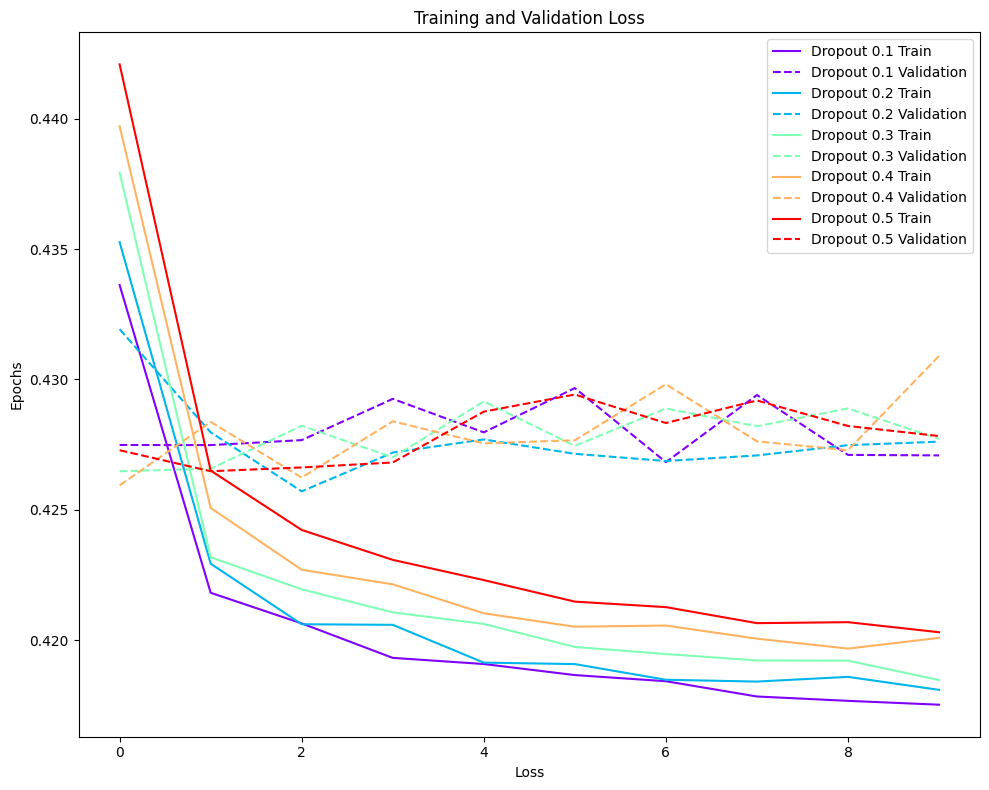

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

# create a colormap
colors = cm.rainbow(np.linspace(0, 1, len(dropout_rates)))

# visualization
fig, ax = plt.subplots(figsize=(10, 8))

for rate, color in zip(dropout_rates, colors):
    ax.plot(loss_df[f'dropout_rate_{rate}_train'], label=f'Dropout {rate} Train', linestyle='-', color=color)
    ax.plot(loss_df[f'dropout_rate_{rate}_val'], label=f'Dropout {rate} Validation', linestyle='--', color=color)
    
ax.set_title('Training and Validation Loss')
ax.set_ylabel('Epochs')
ax.set_xlabel('Loss')
ax.legend()

plt.tight_layout()
plt.show()

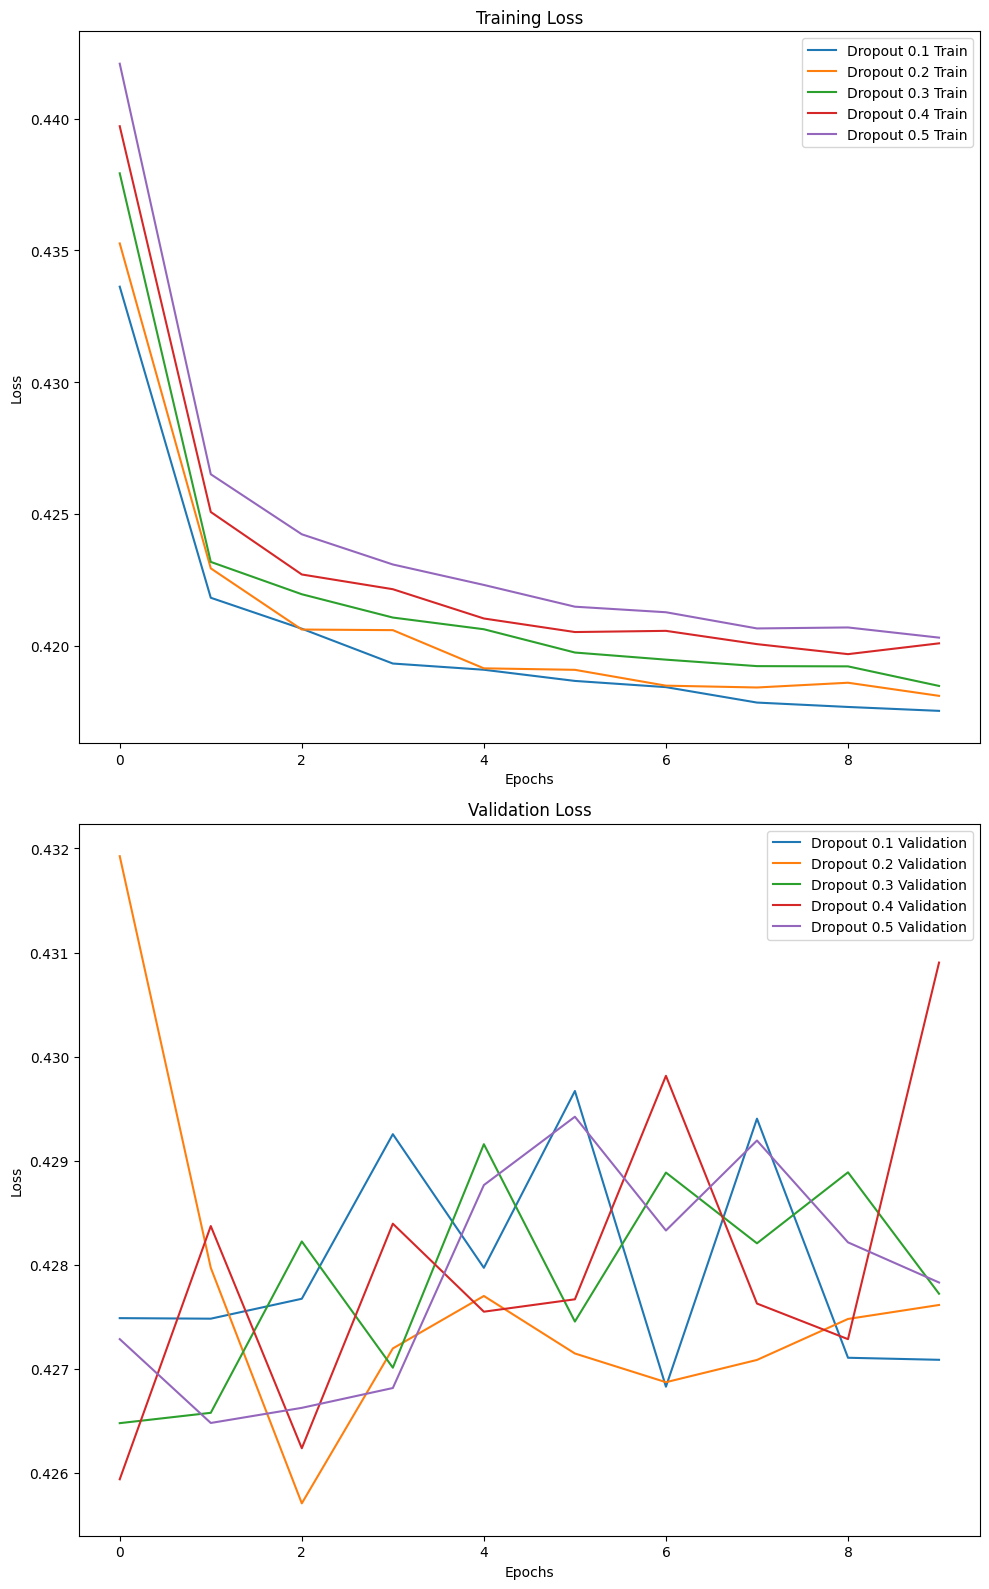

In [20]:
# plot graphs
import matplotlib.pyplot as plt
# visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16))

for rate in dropout_rates:
    ax1.plot(loss_df[f'dropout_rate_{rate}_train'], label=f'Dropout {rate} Train')
    ax2.plot(loss_df[f'dropout_rate_{rate}_val'], label=f'Dropout {rate} Validation')

ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()